# 1. Setup

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor 
from torchvision import transforms
import torch.nn as nn


import matplotlib.pyplot as plt
import math
import torch.nn as nn
import numpy as np
import os
from imutils import paths # list all relative image path

import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader

C:\Users\Minh\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings('ignore')

# 2. Download datasets

In [4]:
!pip install GitPython
from git import Repo

In [5]:
try:
  filepath = "concrete-crack-dataset"
  Repo.clone_from('https://github.com/bimewok/Concrete-Crack-Image-Classifier', filepath)
  # 500 MB of photos
except:
  print("Data already exists")

Data already exists


In [6]:
base_dir = 'concrete-crack-dataset/data/concrete_images/'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val') 
test_dir = os.path.join(base_dir, 'test') 

# 3. Discover and set up data set

Check whether data is imbalanced?

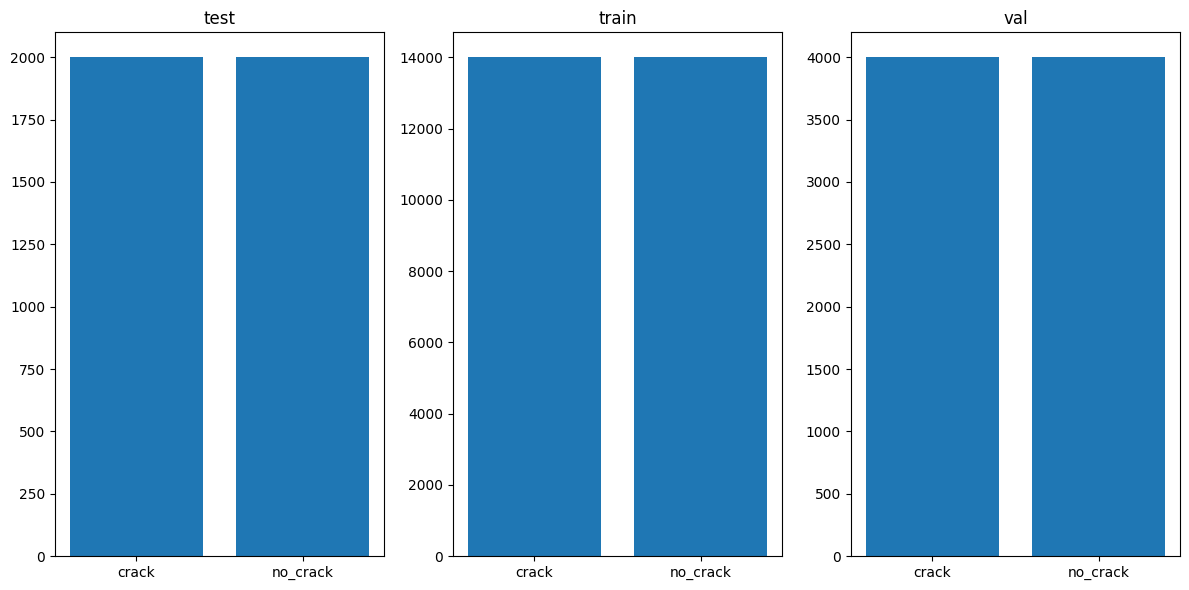

In [7]:

def show_labels(data_dir):
    data = os.listdir(data_dir)
    fig, ax = plt.subplots(1, len(data), figsize=(12,6))
    for idx in range(len(data)):
        sub_dir = os.path.join(data_dir, data[idx])
        labels = os.listdir(sub_dir)
        list_data = []
        for label in labels:
            image_files = list(paths.list_images(os.path.join(sub_dir, label)))
            list_data.append(len(image_files))
        ax[idx].bar(labels, list_data)
        ax[idx].set_title(data[idx])
        # ax[idx].axis('off')
    plt.tight_layout()
    plt.show()
    
show_labels(base_dir)

Plot images

In [8]:
def plot_images(data_dir, label, nrows = 3, ncols = 3):
    """
    Display  `nrows*ncols` images randomly from data_dir folder
    """

    data_dir = os.path.join(data_dir, label)

    image_files = list(paths.list_images(data_dir))
    if len(image_files) == 0:
        print("Does not exist this label. Check again!")
        return 
    fig = plt.figure(figsize = (nrows*ncols -1, nrows*ncols -1))

    for i in range(1, nrows*ncols + 1):
        # sample_idx = tf.random.uniform((1,1), maxval=len(image_files), dtype= tf.dtypes.int32).numpy().item() # lấy ngẫu nhiên các mẫu trong dữ liệu
        sample_idx = torch.randint(len(image_files), size=(1,)).item()
        img = plt.imread(image_files[sample_idx])
        size_image = img.shape
        fig.add_subplot(nrows, ncols, i)
        plt.axis("off")
        plt.imshow(img.squeeze())

    fig.suptitle(label + " " + str(size_image), fontweight = 'bold') 
    plt.tight_layout()

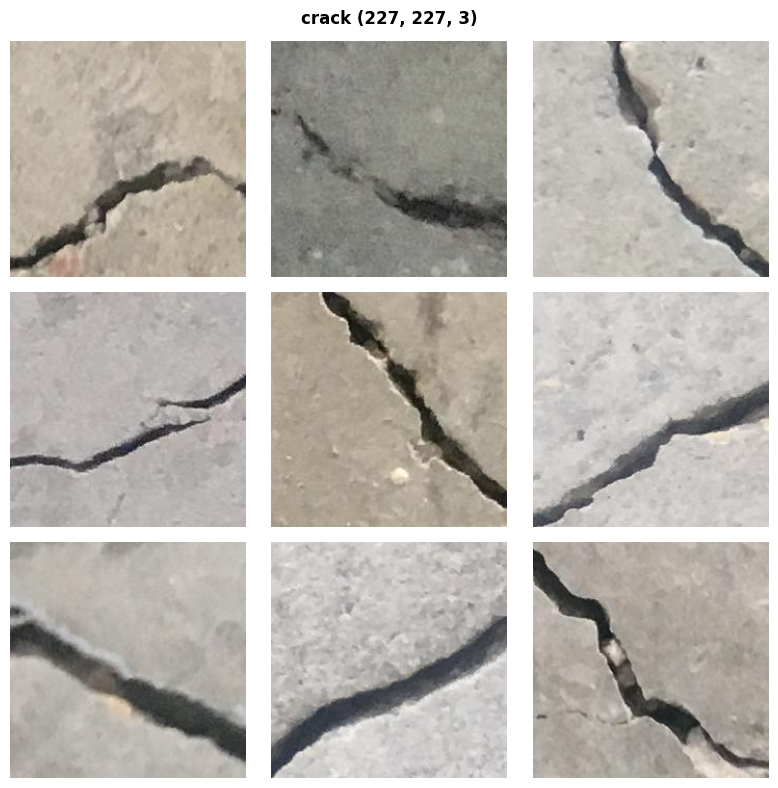

In [9]:
plot_images(train_dir, label="crack")

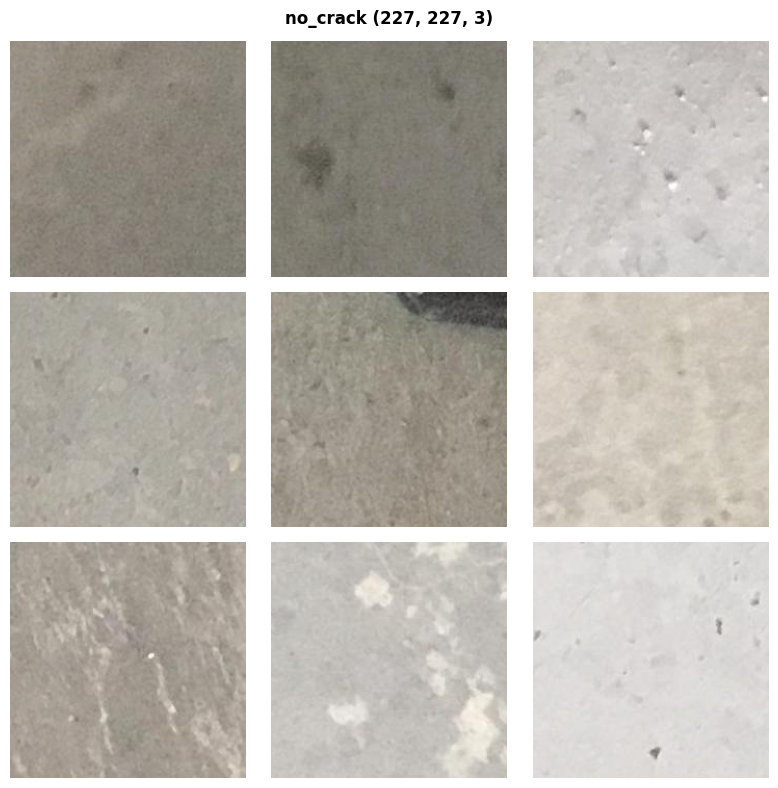

In [10]:
plot_images(train_dir, label="no_crack")


# 4. Device configuration

In [11]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

# 5. Parameters

In [12]:
RANDOM_SEED = 42
LEARNING_RATE = 0.00001
BATCH_SIZE = 256
N_EPOCHS = 10

IMG_SIZE = 227
N_CLASSES = 2

# 6. Load data

Set up path to train/val/test folders

In [13]:
BASE_DIR = "./concrete-crack-dataset/data/concrete_images/"
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VAL_DIR = os.path.join(BASE_DIR, 'val')
TEST_DIR = os.path.join(BASE_DIR, 'test')

Load and transform data

In [14]:
transform = transforms.Compose([transforms.ToTensor()])

training_data = datasets.ImageFolder(root = TRAIN_DIR, transform=transform)
train_dataloader = DataLoader(training_data, batch_size = BATCH_SIZE, shuffle = True)

val_data = datasets.ImageFolder(root= VAL_DIR, transform=transform)
val_dataloader = DataLoader(val_data, batch_size= BATCH_SIZE, shuffle = True)

test_data = datasets.ImageFolder(root = TEST_DIR, transform=transform)
test_dataloader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True)

In [15]:
training_data

Dataset ImageFolder
    Number of datapoints: 28000
    Root location: ./concrete-crack-dataset/data/concrete_images/train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [16]:
train_dataloader

Plot an image

<class 'torch.Tensor'>
torch.Size([256, 3, 227, 227])
torch.Size([3, 227, 227])


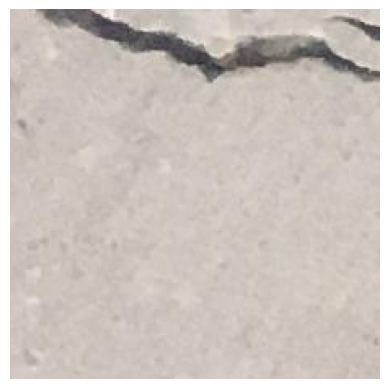

In [17]:
images, labels = next(iter(train_dataloader))
print(type(images[0]))
print(images.shape)
print(images[0].shape)
plt.imshow(images[0].permute(1,2,0).numpy())
plt.axis("off")
plt.show()

# 7. Build Lenet-5 model

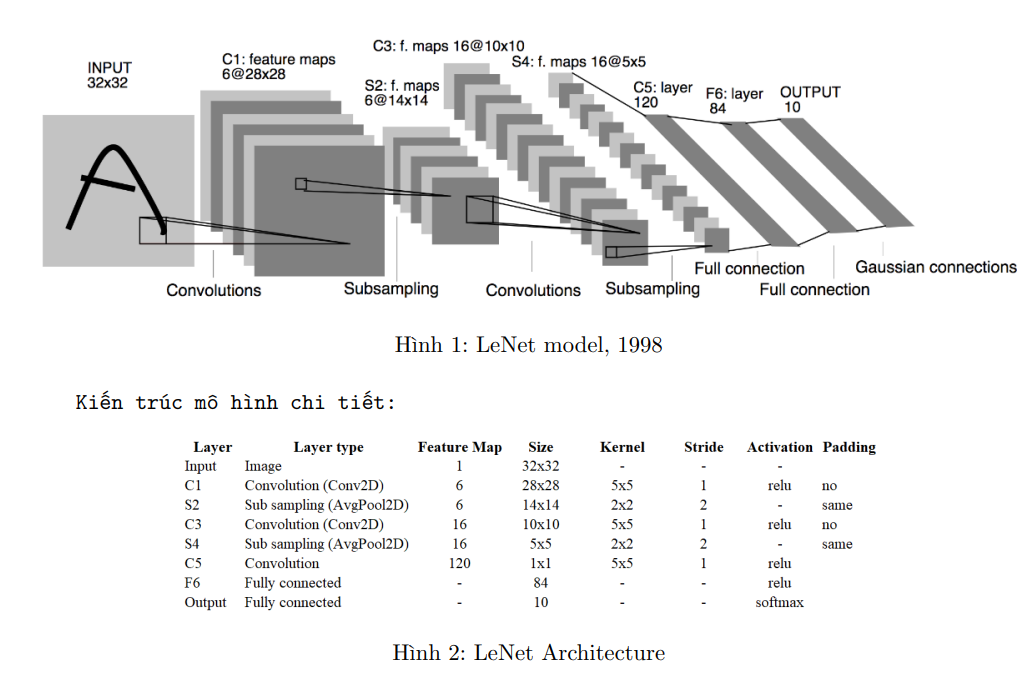

## 7.1 Build network

Image shape: (3, 227, 227). It is not 1x32x32 in the image above.

In [18]:
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super(LeNet5, self).__init__()

    # in_channels: the depth of input image
    # out_channels: No. of filters = the depth of output tensor of layer1. each filter has shape: (kernel_sz x kernel_sz x in_channels) ~ (5x5x3)
    
    #padding = same: want (width, height) of input = (width, height) of output of layer 1  
    # In pytorch, there is not padding = same option. We must manualy calculate padding
    # With padding = ((s-1)(n-1) +(f-1))/2, vì:
    # size of input image is nxn, after a layer is (n+2p-f)/s + 1
    # s: stride, p: size of onesided padding, f: size of kernel
    # So, to padding = same, padding = (1-1)*(227-1) + (5-1)/2 = 2

    # PyTorch can combine the convolutional layer, activation function, and max pooling into one single layer 
    # 3x227x227 -> 6x227x227 -> 6x113x113
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels= 6, kernel_size= 5, stride = 1, padding = 2),
      nn.ReLU(),
      nn.AvgPool2d(kernel_size= 2, stride = 2)
    )

    # 6x113x113 -> 16x109x109 -> 16x54x54
    self.layer2 = nn.Sequential(
      nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size= 5, stride = 1),
      nn.ReLU(),
      nn.AvgPool2d(kernel_size= 2, stride = 2)
    )
    
    # Flatten data: 16*54*54 = 46656
    self.fc1 = nn.Sequential(
      nn.Linear(in_features= 46656, out_features= 84),
      nn.ReLU()
    )

    self.fc2 = nn.Sequential(
      nn.Linear(in_features= 84, out_features= n_classes),
      nn.Sigmoid()
    )

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)

    # flatten the output of layer4 to (batch_size, 16*54*54 )
    out = out.view(out.size(0), -1) # x.size(0) is batch size, x.torch.view to reshape
    out = self.fc1(out)
    out = self.fc2(out)
    
    return out


In [19]:
# ''' 
# Another
# '''
# class LeNet5(nn.Module):
#   def __init__(self, n_classes):
#     super(LeNet5, self).__init__()

#     self.layer1 = nn.Conv2d(in_channels=3, out_channels= 6, kernel_size= 5, stride = 1, padding = 2),
#     self.relu1 = nn.ReLU(),
#     self.layer2 = nn.AvgPool2d(kernel_size= 2, stride = 2),
#     self.layer3 = nn.Conv2d(in_channels= 6, out_channels= 16, kernel_size= 5, stride = 1),
#     self.relu2 = nn.ReLU(),
#     self.layer4 = nn.AvgPool2d(kernel_size= 2, stride = 2)


## 7.2 Initialize model

In [20]:
torch.manual_seed(RANDOM_SEED)
model = LeNet5(N_CLASSES).to(DEVICE)
print(model)

LeNet5(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc1): Sequential(
    (0): Linear(in_features=46656, out_features=84, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=84, out_features=2, bias=True)
    (1): Sigmoid()
  )
)


## 7.3 Loss and optimizer

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

## 7.4 Train

### 7.4.1 Helper function

In [22]:
'''
  Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
  correct = 0
  total = 0
  
  with torch.no_grad(): #  sets all of the requires_grad flags to false
    model.eval() # set dropout and batch normalization layers to evaluation mode
    for images, labels in data_loader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  return 100*(correct/total)

In [23]:
'''
  Function for plotting training and validation losses
'''
def plot_losses(train_losses, valid_losses):
  # change the style of the plots to seaborn
  plt.style.use('seaborn')

  train_losses = np.array(train_losses)
  valid_losses = np.array(valid_losses)

  fig, ax = plt.subplots(figsize=(8, 4.5))

  ax.plot(train_losses, color="blue", label="Training_loss")
  ax.plot(valid_losses, color="red", label="Validation_loss")
  ax.set(title="Loss over epochs",
          xlabel="Epoch",
          ylabel="Loss")
  ax.legend()
  fig.show()

  # change the plot style to default
  plt.style.use('default')

In [24]:
'''
  function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
  model.train()
  running_loss = 0

  for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()

    # backward and optimizer
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  epoch_loss = running_loss / len(train_loader.dataset)

  return model, optimizer, epoch_loss 

In [25]:
'''
  function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
  model.eval()
  running_loss = 0

  for images, labels in valid_loader:
    images = images.to(device)
    labels = labels.to(device)

    # forward pass and record loss
    outputs = model(images)
    loss = criterion(outputs, labels)
    running_loss += loss.item()
  
  epoch_loss = running_loss / len(valid_loader.dataset)

  return model, epoch_loss



In [26]:
'''
  function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
  # set object for storing metrics
  best_loss = 1e10
  train_losses = []
  valid_losses = []

  # train model
  for epoch in range(0, epochs):
    # training
    model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
    train_losses.append(train_loss)

    # validation
    with torch.no_grad():
      model, valid_loss = validate(valid_loader, model, criterion, device)
      valid_losses.append(valid_loss)

    if epoch % print_every == print_every - 1:
      train_acc = get_accuracy(model, train_loader, device=device)
      valid_acc = get_accuracy(model, valid_loader, device=device)

      print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc
            ))

  plot_losses(train_losses, valid_losses)

  return model, optimizer, (train_losses, valid_losses)

### 7.4.2 Train model

Epochs: 0, Train_loss: 0.0026966598140341896, Valid_loss: 0.002708736442029476, Train_accuracy: 55.40714285714286, Valid_accuracy: 57.074999999999996
Epochs: 1, Train_loss: 0.002634740235550063, Valid_loss: 0.0026207034662365913, Train_accuracy: 76.02499999999999, Valid_accuracy: 80.1875
Epochs: 2, Train_loss: 0.002544005166207041, Valid_loss: 0.0024974231645464896, Train_accuracy: 74.03214285714286, Valid_accuracy: 78.7875
Epochs: 3, Train_loss: 0.0024034584228481565, Valid_loss: 0.0023368512317538262, Train_accuracy: 82.90357142857144, Valid_accuracy: 85.2625
Epochs: 4, Train_loss: 0.0022532146679503577, Valid_loss: 0.00219793039560318, Train_accuracy: 82.74285714285713, Valid_accuracy: 84.95
Epochs: 5, Train_loss: 0.0021363684045416966, Valid_loss: 0.0020841749757528304, Train_accuracy: 85.92857142857143, Valid_accuracy: 87.4625
Epochs: 6, Train_loss: 0.002019955907549177, Valid_loss: 0.0019920108616352083, Train_accuracy: 86.75714285714285, Valid_accuracy: 87.9625
Epochs: 7, Train_

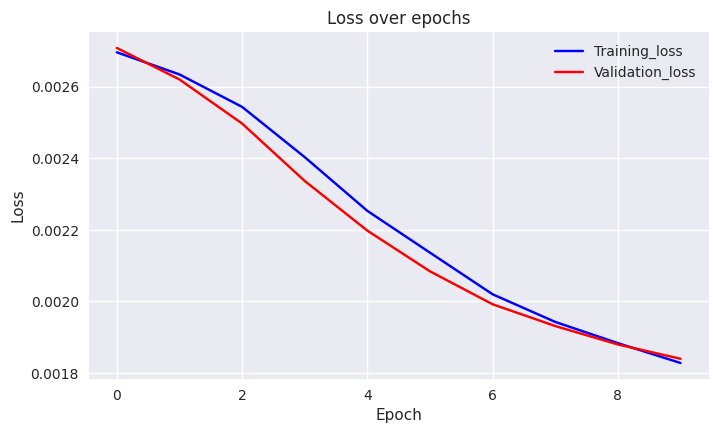

In [27]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_dataloader, val_dataloader, N_EPOCHS, DEVICE)

## 7.5 Save model

In [28]:
PATH = './save_model/LeNet_model.ckpt'

In [29]:
torch.save(model.state_dict(), PATH)

In [30]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

# Reference
1. https://d2l.ai/chapter_convolutional-neural-networks/lenet.html
2. https://www.kaggle.com/code/leifuer/intro-to-pytorch-loading-image-data
3. https://blog.paperspace.com/writing-lenet5-from-scratch-in-python/#:~:text=LeNet5%20is%20one%20of%20the,the%20recognition%20of%20handwritten%20characters.